# 패키지 로딩 및 환경 준비

In [1]:
# 필요한 기본 패키지 준비
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats

%matplotlib inline
from plotnine import *
import folium
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import datetime as dt

# 한글 처리
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# jupyter notebook에서 warning 무시하기
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 아웃라이어 찾기 (MAD기반)
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

In [3]:
# 데이터 불러오기(전처리 된 데이터)
lavla = pd.read_csv('E:/Python/처리된 csv자료/p_lavla.csv')
weather = pd.read_csv('E:/Python/처리된 csv자료/p_weather.csv')

# lavla,서울,선케어, 2016~2018

In [4]:
# lavla,서울,선케어, 2016~2018
col_to_use = ['pvn_nm','gender','qty','date','category']
lavla_seoul_suncare_all = lavla.loc[(lavla['category']=='선케어')&(lavla['pvn_nm']=='서울특별시')]
df1 = lavla_seoul_suncare_all[col_to_use].groupby(by=['date','pvn_nm','category']).sum().reset_index()
w_s_all = weather.loc[(weather['loc']==108),['date','temp','humid','wind','rain','snow','cloud']]
df1_w_s_all = pd.merge(df1, w_s_all, on='date', how='left')

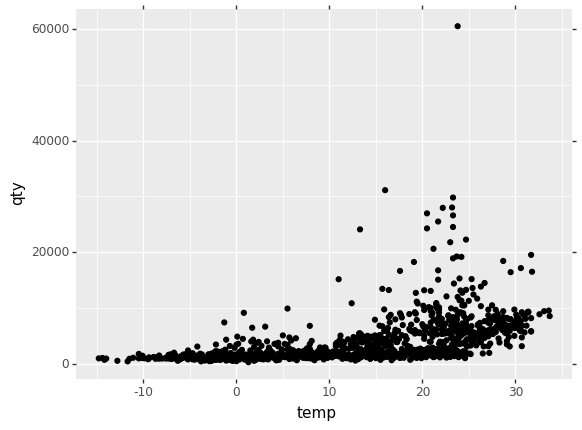

<ggplot: (-9223371922930797522)>

In [5]:
# lavla,서울,선케어, 2016~2018년
(
    ggplot(df1_w_s_all)
    + aes(x='temp', y='qty')
    + geom_point()
)

In [6]:
# 랄라블라 판매 데이터에 이상치 T/F 열추가 (MAD)
df1 = pd.DataFrame(mad_based_outlier(df1_w_s_all['qty']), columns = ['out'])
df1[df1['out'] == True]
df1_w_s_all['out']=df1
df1_w_s_all.head()

# 이상치 == True 이므로 out=True 행 제거
df1_w_s_all = df1_w_s_all[df1_w_s_all.out != True]

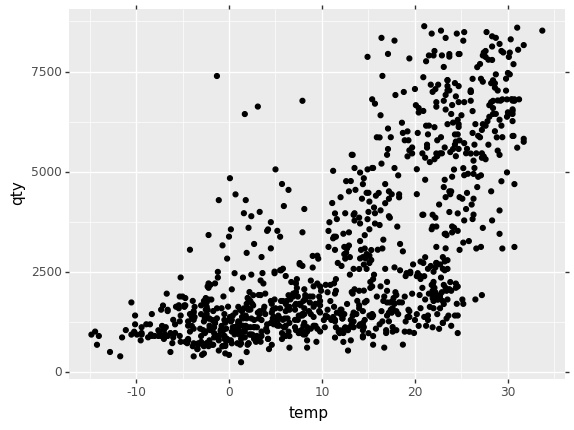

<ggplot: (113926341082)>

In [7]:
# lavla,서울,선케어, 2016~2018년
(
    ggplot(df1_w_s_all)
    + aes(x='temp', y='qty')
    + geom_point()
)

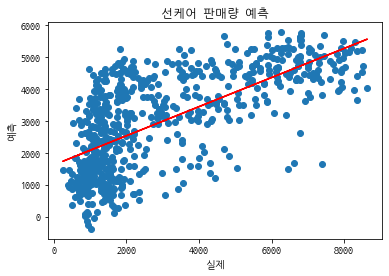

In [8]:
df1_w_s_all['date'] = pd.to_datetime(df1_w_s_all['date'])
using_cols=['date','temp','humid','wind','rain','snow','cloud','qty']
df_train = df1_w_s_all.loc[(df1_w_s_all['date']<='2017-12-31'), using_cols]
df_test = df1_w_s_all.loc[(df1_w_s_all['date']>='2018-01-01'), using_cols]
df_train_data = df_train.iloc[:,1:-1]
df_train_target = df_train.iloc[:,7]
df_test_data = df_test.iloc[:,1:-1]
df_test_target = df_test.iloc[:,7]

model = LinearRegression().fit(df_train_data, df_train_target)
predicted = model.predict(df_train_data)
plt.scatter(df_train_target, predicted)
plt.xlabel('실제')
plt.ylabel('예측')
plt.title('선케어 판매량 예측')
# plt.show()

# 회귀선
result = stats.linregress(df_train_target,predicted)
slope, intercept, r_value, p_value, std_err = result
x = np.array(df_train_target)
plt.plot(x, intercept+slope*x, c='red')
plt.show()

### 선형 회귀 분석 (Linear regression analysis)

In [9]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,7]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

# fit() : 머신러닝 즉, 주어진 데이터를 가지고 기계학습을 시키는 명령
# 회귀분석모델에 데이터를 입력하여 기계학습 실시
model = LinearRegression().fit(X_train, y_train)
print(model)

# 훈련데이터셋
model.score(X_train, y_train) 
# 검증 데이터셋을 가지고 예측결과
model.score(df_test.iloc[:,1:-1], (df_test.iloc[:,7]))

print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

(462, 6) (199, 6)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
훈련세트점수 : 0.45
검증세트점수 : 0.47


### 리지 회귀분석(ridge regression)

In [10]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,7]

print(X_train.shape, X_test.shape)

# fit() : 머신러닝 즉, 주어진 데이터를 가지고 기계학습을 시키는 명령
# 회귀분석모델에 데이터를 입력하여 기계학습 실시
ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
print(ridge)

print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))

(462, 6) (199, 6)
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=0, solver='auto', tol=0.001)
훈련세트점수 : 0.44
검증세트점수 : 0.48


### OLS(Ordinary Least Squares) 결정론적 선형 회귀 방법

In [11]:
col_to_use = ['pvn_nm','gender','qty','date','category']
lavla_seoul_suncare_all = lavla.loc[(lavla['category']=='선케어')&(lavla['pvn_nm']=='서울특별시')]
df1 = lavla_seoul_suncare_all[col_to_use].groupby(by=['date','pvn_nm','category']).sum().reset_index()
w_s_all = weather.loc[(weather['loc']==108),['date','temp','humid','wind','rain','snow','cloud','sun_time']]
df1_w_s_all = pd.merge(df1, w_s_all, on='date', how='left')
df1_w_s_all['date'] = pd.to_datetime(df1_w_s_all['date'])
using_cols=['date','temp','humid','wind','rain','snow','cloud','sun_time','qty']
df_train = df1_w_s_all.loc[(df1_w_s_all['date']<='2017-12-31'), using_cols]
df_test = df1_w_s_all.loc[(df1_w_s_all['date']>='2018-01-01'), using_cols]

# 그냥 손으로 다 때려 넣은 'qty'를 온도,강수량,구름 등을 변수로 예측
# experiment_mo = sm.OLS.from_formula("qty ~ temp + humid + wind + rain + snow + cloud + sun_time", data=df_train) # 0.492
# experiment_mo = sm.OLS.from_formula("qty ~ temp + humid + wind + rain + cloud + sun_time", data=df_train) # 0.492
# experiment_mo = sm.OLS.from_formula("qty ~ temp + humid", data=df_train) # 0.294
# experiment_mo = sm.OLS.from_formula("qty ~ temp", data=df_train)  # 0.266
experiment_mo = sm.OLS.from_formula("qty ~ I(np.exp(temp)) + humid + wind + sun_time", data=df_train)  # 0.480

# 현재 편의를 위해 제작된 함수는 'temp'변수만을 1~5차 까지 늘려서 예측
# experiment_mo = formula_gen(5)
print(experiment_mo.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     167.8
Date:                Thu, 22 Aug 2019   Prob (F-statistic):          1.13e-101
Time:                        22:05:41   Log-Likelihood:                -6901.7
No. Observations:                 731   AIC:                         1.381e+04
Df Residuals:                     726   BIC:                         1.384e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.406e+04    933.901    -

# lavla,서울,제모제, 2016~2018

In [12]:
# lavla,서울,제모제, 2016~2018
col_to_use = ['pvn_nm','gender','qty','date','category']
lavla_seoul_removal_all = lavla.loc[(lavla['category']=='제모제')&(lavla['pvn_nm']=='서울특별시')]
df2 = lavla_seoul_removal_all[col_to_use].groupby(by=['date','pvn_nm','category']).sum().reset_index()
w_s_all = weather.loc[(weather['loc']==108),['date','temp','humid','wind','rain','snow','cloud']]
df2_w_s_all = pd.merge(df2, w_s_all, on='date', how='left')

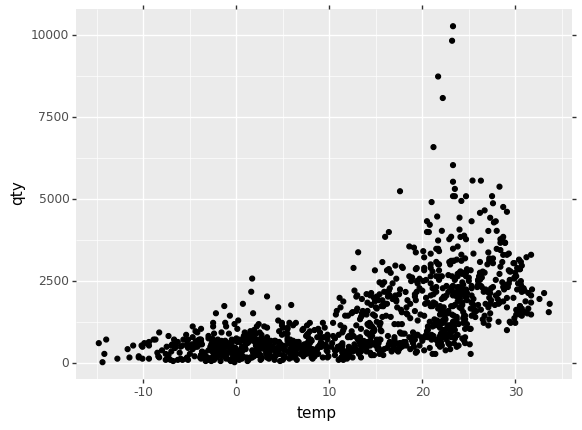

<ggplot: (-9223371922922858748)>

In [13]:
# lavla,서울,제모제, 2016~2018년
(
    ggplot(df2_w_s_all)
    + aes(x='temp', y='qty')
    + geom_point()
)

In [14]:
# 랄라블라 판매 데이터에 이상치 T/F 열추가 (MAD)
df2 = pd.DataFrame(mad_based_outlier(df2_w_s_all['qty']), columns = ['out'])
df2[df2['out'] == True]
df2_w_s_all['out']=df2
df2_w_s_all.head()

# 이상치 == True 이므로 out=True 행 제거
df2_w_s_all = df2_w_s_all[df2_w_s_all.out != True]

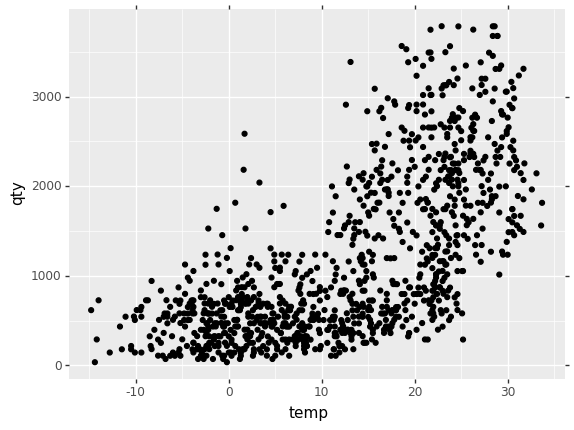

<ggplot: (-9223371922922961285)>

In [15]:
# lavla,서울,제모제, 2016~2018년
(
    ggplot(df2_w_s_all)
    + aes(x='temp', y='qty')
    + geom_point()
)

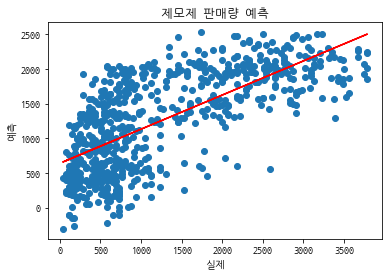

In [16]:
df2_w_s_all['date'] = pd.to_datetime(df2_w_s_all['date'])
using_cols=['date','temp','humid','wind','rain','snow','cloud','qty']
df_train = df2_w_s_all.loc[(df2_w_s_all['date']<='2017-12-31'), using_cols]
df_test = df2_w_s_all.loc[(df2_w_s_all['date']>='2018-01-01'), using_cols]
df_train_data = df_train.iloc[:,1:-1]
df_train_target = df_train.iloc[:,7]
df_test_data = df_test.iloc[:,1:-1]
df_test_target = df_test.iloc[:,7]

model = LinearRegression().fit(df_train_data, df_train_target)
predicted = model.predict(df_train_data)
plt.scatter(df_train_target, predicted)
plt.xlabel('실제')
plt.ylabel('예측')
plt.title('제모제 판매량 예측')
# plt.show()

# 회귀선
result = stats.linregress(df_train_target,predicted)
slope, intercept, r_value, p_value, std_err = result
x = np.array(df_train_target)
plt.plot(x, intercept+slope*x, c='red')
plt.show()

In [17]:
### 선형 회귀 분석 (Linear regression analysis)

In [18]:
from sklearn.model_selection import train_test_split

X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,7]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

# fit() : 머신러닝 즉, 주어진 데이터를 가지고 기계학습을 시키는 명령
# 회귀분석모델에 데이터를 입력하여 기계학습 실시
model = LinearRegression().fit(X_train, y_train)
print(model)

# 훈련데이터셋
model.score(X_train, y_train) 
# 검증 데이터셋을 가지고 예측결과
model.score(df_test.iloc[:,1:-1], (df_test.iloc[:,7]))

print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

(480, 6) (207, 6)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
훈련세트점수 : 0.51
검증세트점수 : 0.45


In [19]:
### 리지 회귀분석(ridge regression)

In [20]:
from sklearn.linear_model import Ridge
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,7]

print(X_train.shape, X_test.shape)

# fit() : 머신러닝 즉, 주어진 데이터를 가지고 기계학습을 시키는 명령
# 회귀분석모델에 데이터를 입력하여 기계학습 실시
ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
print(ridge)

print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))

(480, 6) (207, 6)
Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=0, solver='auto', tol=0.001)
훈련세트점수 : 0.50
검증세트점수 : 0.46


In [21]:
### OLS(Ordinary Least Squares) 결정론적 선형 회귀 방법

In [22]:
import statsmodels.api as sm
col_to_use = ['pvn_nm','gender','qty','date','category']
lavla_seoul_removal_all = lavla.loc[(lavla['category']=='제모제')&(lavla['pvn_nm']=='서울특별시')]
df2 = lavla_seoul_removal_all[col_to_use].groupby(by=['date','pvn_nm','category']).sum().reset_index()
w_s_all = weather.loc[(weather['loc']==108),['date','temp','humid','wind','rain','snow','cloud','sun_time']]
df2_w_s_all = pd.merge(df2, w_s_all, on='date', how='left')
df2_w_s_all['date'] = pd.to_datetime(df2_w_s_all['date'])
using_cols=['date','temp','humid','wind','rain','snow','cloud','sun_time','qty']
df_train = df2_w_s_all.loc[(df2_w_s_all['date']<='2017-12-31'), using_cols]
df_test = df2_w_s_all.loc[(df2_w_s_all['date']>='2018-01-01'), using_cols]

# 그냥 손으로 다 때려 넣은 'qty'를 온도,강수량,구름 등을 변수로 예측
experiment_mo = sm.OLS.from_formula("qty ~ temp + humid + wind + rain + snow + cloud + sun_time", data=df_train) # 0.56
# experiment_mo = sm.OLS.from_formula("qty ~ temp + humid + wind + rain + cloud + sun_time", data=df_train) # 0.558
# experiment_mo = sm.OLS.from_formula("qty ~ temp + humid", data=df_train) # 0.4
# experiment_mo = sm.OLS.from_formula("qty ~ temp", data=df_train)  # 0.440

# 현재 편의를 위해 제작된 함수는 'temp'변수만을 1~5차 까지 늘려서 예측
# experiment_mo = formula_gen(5)
print(experiment_mo.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     131.4
Date:                Thu, 22 Aug 2019   Prob (F-statistic):          2.92e-124
Time:                        22:05:42   Log-Likelihood:                -6004.6
No. Observations:                 730   AIC:                         1.203e+04
Df Residuals:                     722   BIC:                         1.206e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5449.2248    429.193    -12.696      0.0